In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from img_util import ImageDataLoader as IDL

In [8]:
def removeHair_v6(image_rgb, image_gray, mask):

    # apply mask to images
    image_rgb_mask = image_rgb.copy()
    image_rgb_mask[mask == 0] = [0, 0, 0]

    image_gray_mask = image_gray.copy()
    image_gray_mask[mask == 0] = 0

    # convert scale of img to make it compatible w otsu thresholding
    image_gray_mask = cv2.convertScaleAbs(image_gray_mask)

    # compute threshold
    _, binary_gray = cv2.threshold(image_gray_mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # convert to grayscale and blur to reduce noise
    img_blurred = cv2.GaussianBlur(image_gray_mask, (5, 5), 1)

    # compute threshold
    thresh, _ = cv2.threshold(img_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # compute bounds for Canny
    low = 0.5 * thresh
    high = 1.5 * thresh
    
    # find (hopefully) hair edges
    edges = cv2.Canny(img_blurred, low, high)

    # thicken the edges
    kernel = np.ones((3, 3), np.uint8) 
    thick_edges = cv2.dilate(edges, kernel, iterations=1)


    # set up kernels to find differently-positioned hair

    kernel_1 = np.array([[0, 1, 0],
                         [0, 1, 0],
                         [0, 1, 0]], dtype=np.uint8)
    
    kernel_2 = np.array([[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]], dtype=np.uint8)
    
    kernel_3 = np.array([[0, 0, 0],
                         [1, 1, 1],
                         [0, 0, 0]], dtype=np.uint8)

    # run hitmiss with each kernel on the edge image
    hm1 = cv2.morphologyEx(binary_gray, cv2.MORPH_HITMISS, kernel_1)
    hm2 = cv2.morphologyEx(binary_gray, cv2.MORPH_HITMISS, kernel_2)
    hm3 = cv2.morphologyEx(binary_gray, cv2.MORPH_HITMISS, kernel_3)

    # combine results
    combined_mask = cv2.bitwise_or(thick_edges, hm1)
    combined_mask = cv2.bitwise_or(combined_mask, hm2)
    combined_mask = cv2.bitwise_or(combined_mask, hm3)


    # dilate the combined mask

    # define the kernel 
    kernel_dil = np.ones((3, 3), np.uint8)  
    
    # dilate the mask
    mask_dilated = cv2.dilate(combined_mask, kernel_dil, iterations=1)

    # inpaint image
    inpainted_image = cv2.inpaint(image_rgb_mask, mask_dilated, inpaintRadius=3, flags=cv2.INPAINT_NS)
    # inpainted_image = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)

    result = np.where(inpainted_image > 25, inpainted_image, image_rgb_mask)

    return image_rgb_mask, inpainted_image, result
  

In [6]:
# set up relevant directories
img_dir = '../data/lesion_imgs/'
mask_dir = '../data/lesion_masks/'

# load up the images and relative masks
data_loader = IDL(img_dir, mask_dir)

data_iterator = iter(data_loader)

In [4]:
# skip random n of images
n = random.randint(0, 2000)
print(n)
for _ in range(n):
    next(data_iterator)

154


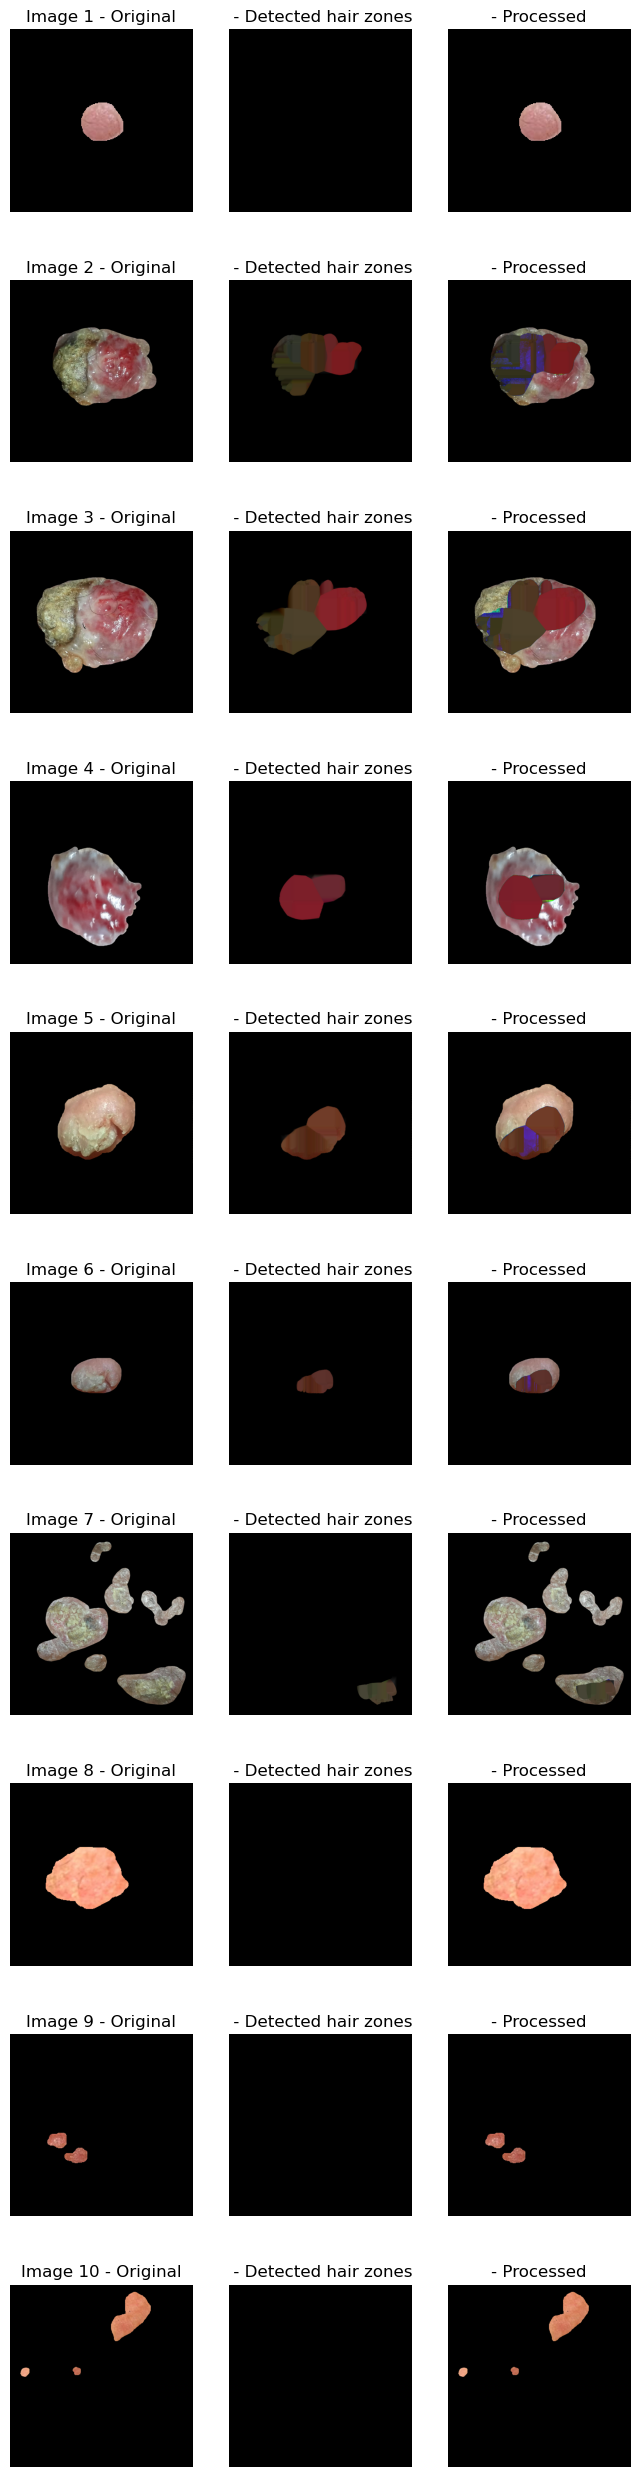

In [14]:
# plot 10 random imgs

fig, axes = plt.subplots(10, 3, figsize= (8, 32))

for i in range(10):

    img_rgb, img_gray, mask, name = next(data_iterator)
    img_rgb_mask, inp_img, img_noH = removeHair_v6(img_rgb, img_gray, mask)

    axes[i, 0].imshow(img_rgb_mask)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(inp_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f" - Detected hair zones")

    axes[i, 2].imshow(img_noH)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f"- Processed")

plt.show()

In [2]:
def removeHair_v1(img_org, img_gray, kernel_size=25, threshold=10, radius=3):
    
    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, threshold, 255, cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

In [3]:
def removeHair_v2(img_org, img_gray, kernel_size=25, threshold=10, radius=3):
    
    # v2 ADDITION
    img_gray_eq = cv2.equalizeHist(img_gray)

    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray_eq, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray_eq, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, threshold, 255, cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

In [4]:
def removeHair_v3(img_org, img_gray, kernel_size=25, threshold=10, radius=3):

    # v3 ADDITION: MORPH_RECT
    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, threshold, 255, cv2.THRESH_BINARY)

    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

In [5]:
def removeHair_v4(img_org, img_gray, kernel_size=25, radius=3):

    # v3 ADDITION: MORPH_RECT
    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # v4 ADDITION: adaptive thresholding
    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_TELEA)
    
    return hat_img, thresh, img_out

In [6]:
def removeHair_v5(img_org, img_gray, kernel_size=25, radius=3):

    # kernel for the morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))


    # perform filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel)

    hat_img = cv2.add(blackhat, tophat)  # This properly merges them

    # v4 ADDITION: adaptive thresholding
    # intensify the hair countours in preparation for the inpainting algorithm
    _, thresh = cv2.threshold(hat_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # v5 ADDITION: inpaint_ns
    # inpaint the original image depending on the mask
    img_out = cv2.inpaint(img_org, thresh, radius, cv2.INPAINT_NS)
    
    return hat_img, thresh, img_out

#### 1. Test original removeHair()

Outcome: pretty bad, a lot of details lost

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 2, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, _, img_noH = removeHair_v1(img, img_gray)
    img_noH = cv2.cvtColor(img_noH, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image {i+1} - Processed")

    i += 1
plt.show()   

#### 2. Test version 2 of removeHair() 
Addition: equalized grayscale image

Outcome: same as v1

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 2, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, _, img_noH = removeHair_v2(img, img_gray)
    img_noH = cv2.cvtColor(img_noH, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image {i+1} - Processed")

    i += 1
plt.show()  

#### 3. Test version 3 of removeHair() 
Addition: morph_rect morphological kernel

Outcome: even worse than v1

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 2, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, _, img_noH = removeHair_v3(img, img_gray)
    img_noH = cv2.cvtColor(img_noH, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image {i+1} - Processed")

    i += 1
plt.show()  

#### 4. Test version 4 of removeHair() 
Addition: adaptive Otsu thresholding

Outcome: definitely better, still does more harm than good imo

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 2, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, _, img_noH = removeHair_v4(img, img_gray)
    img_noH = cv2.cvtColor(img_noH, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image {i+1} - Processed")

    i += 1
plt.show()  

#### 5. Test version 5 of removeHair() 
Addition: using inpaint_ns

Outcome: definitely the best, still not that great

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 2, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, _, img_noH = removeHair_v5(img, img_gray)
    img_noH = cv2.cvtColor(img_noH, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Image {i+1} - Processed")

    i += 1
plt.show()  

Final test

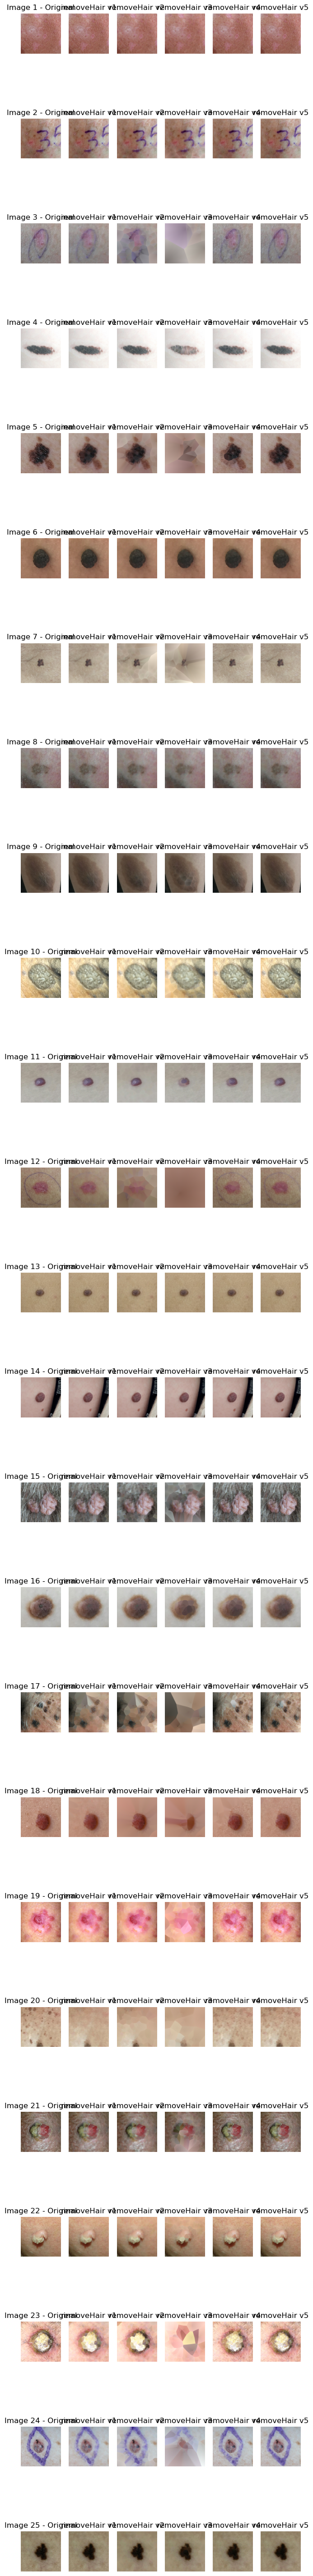

In [ ]:
folder_path = "../data/test"
i = 0

fig, axes = plt.subplots(25, 6, figsize= (8, 75))
# list all files
image_files = sorted(os.listdir(folder_path)) 

# iterate through the images
for filename in image_files:

    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    _, _, img_noH_v1 = removeHair_v1(img, img_gray)
    img_noH_v1 = cv2.cvtColor(img_noH_v1, cv2.COLOR_BGR2RGB)

    _, _, img_noH_v2 = removeHair_v2(img, img_gray)
    img_noH_v2 = cv2.cvtColor(img_noH_v2, cv2.COLOR_BGR2RGB)

    _, _, img_noH_v3 = removeHair_v3(img, img_gray)
    img_noH_v3 = cv2.cvtColor(img_noH_v3, cv2.COLOR_BGR2RGB)

    _, _, img_noH_v4 = removeHair_v4(img, img_gray)
    img_noH_v4 = cv2.cvtColor(img_noH_v4, cv2.COLOR_BGR2RGB)

    _, _, img_noH_v5 = removeHair_v5(img, img_gray)
    img_noH_v5 = cv2.cvtColor(img_noH_v5, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {i+1} - Original")

    axes[i, 1].imshow(img_noH_v1)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"v1")

    axes[i, 2].imshow(img_noH_v2)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f"v2")

    axes[i, 3].imshow(img_noH_v3)
    axes[i, 3].axis('off')
    axes[i, 3].set_title(f"v3")

    axes[i, 4].imshow(img_noH_v4)
    axes[i, 4].axis('off')
    axes[i, 4].set_title(f"v4")

    axes[i, 5].imshow(img_noH_v5)
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f"v5")

    i += 1
plt.show()  